In [421]:
import pandas as pd
import numpy as np

import copy
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import torch.nn as nn

from tqdm import tqdm # import tqdm 시 모듈 에러 발생
from sklearn.decomposition import PCA  

# import xgboost as xgb
import lightgbm as lgb
import random
from sklearn.metrics import mean_squared_error

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from statsmodels.stats.outliers_influence import variance_inflation_factor


def set_seed(seed): 
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN의 결정론적 연산 보장
    torch.backends.cudnn.benchmark = False  # CuDNN의 비결정적 알고리즘 비활성화
    random.seed(seed)
    np.random.seed(seed)

In [2]:
print("-------------------------- Use library version --------------------------")
print(f"Numpy_Version: ",{np.__version__})
print(f"Pandas_Version: ", {pd.__version__})
print(f"scikit-learn version: ",{sklearn.__version__})
print(f"'Pytorch_Version: ", {torch.__version__})
print(f"LightGBM_Version: ", {lgb.__version__})
print("---------------------------------------------------------------------")

-------------------------- Use library version --------------------------
Numpy_Version:  {'1.24.3'}
Pandas_Version:  {'2.2.2'}
scikit-learn version:  {'1.4.2'}
'Pytorch_Version:  {'2.3.1'}
LightGBM_Version:  {'4.5.0'}
---------------------------------------------------------------------


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
tr_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv') # 경진대회 /기간이 끝나서 테스트 데이터 사용 x

In [5]:
train = copy.copy(tr_df.drop(['y','ID'], axis =1))
train_y = copy.copy(tr_df['y'])

tr, validation, tr_y, validation_y = train_test_split(train, train_y, random_state=20, test_size=0.2)
val, test, val_y, test_y = train_test_split(validation, validation_y, random_state=20, test_size=0.5)


def dataframe_shape(df):
    print(f'Shape: {df.shape}')

dataframe_shape(tr)
dataframe_shape(val)
dataframe_shape(test)
dataframe_shape(tr_y)
dataframe_shape(val_y)
dataframe_shape(test_y)

Shape: (32094, 11)
Shape: (4012, 11)
Shape: (4012, 11)
Shape: (32094,)
Shape: (4012,)
Shape: (4012,)


# Random Forest 적용

In [154]:
# cross validation을 사용하여 기존에 나눴던 훈련용, 검증용 concat 

for_tree_tr = pd.concat([tr, val], axis=0)
for_tree__tr_y = pd.concat([tr_y, val_y], axis= 0)

In [71]:
rfr = RandomForestRegressor(random_state=43, n_jobs= -1)

random_params = {
    'n_estimators' : range(10,150,20),
    'max_depth' : [-1, 4,5],
    'min_samples_leaf' :  [10,11,12],
    'max_features' : np.arange(0.6, 1.01, 0.1)
}

n_iter = 300

start = time.time()

random_rfr = RandomizedSearchCV(rfr, 
                                param_distributions=random_params,
                                n_iter = n_iter,
                                cv = 5,
                                scoring = 'neg_mean_squared_error',
                                random_state = 43)

random_rfr.fit(for_tree_tr.values, for_tree__tr_y.values)

print(f'Random Forest Regressor 학습 소요시간:{np.round(time.time() - start, 0)}sec')

Random Forest Regressor 학습 소요시간:443.0sec


In [73]:
# 아무런 전처리 적용하지 않고 바로 RandomForest 적용했을 때 cv=5, validation Performance
vanila_rfr_result = pd.DataFrame(random_rfr.cv_results_)
result_sorted = vanila_rfr_result.sort_values('mean_test_score', ascending=False)

random_rfr_best_model = random_rfr.best_estimator_
print(random_rfr_best_model)
random_rfr_best_model.fit(for_tree_tr.values, for_tree__tr_y.values)

vanila_rfr_perds = random_rfr_best_model.predict(test.values)

# 예측 값 중 상위 10% 선별
rf_preds_10_threshold = np.percentile(vanila_rfr_perds, 90)
print(f'Top_10%_threshold : {rf_preds_10_threshold}')
rf_pred_binary =(vanila_rfr_perds >= rf_preds_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'예측 상위 10% 중, 실제 상위 5% 포함 비율 : {np.round(recall_score(true_binary, rf_pred_binary), 5)}')

RandomForestRegressor(max_depth=5, max_features=0.7999999999999999,
                      min_samples_leaf=12, n_estimators=110, n_jobs=-1,
                      random_state=43)
Top_10%_threshold : 86.32085485822003
예측 상위 10% 중, 실제 상위 5% 포함 비율 : 0.86567


# LGBM Reressor 적용

In [155]:
# 모델을 바꿔서 적용해보기

lgb_reg = lgb.LGBMRegressor(random_state=43, n_jobs=-1, verbose=-1)

lgbreg_random_params ={
            'max_depth' : [-1,3,4,5],  # 파라미터 지정하지 않으면 기본 값-1 부여 -> 이는 제한을 두지 않겠다는 의미
            'num_leaves' : [3,4,5,6,7],  # 트리 당 리프 개수  보통 2^max_depth 보다 1 작게!  (2^3-1 = 7)
            'n_estimators' : range(30,100,10),  # 트리 개수  보통 학습률 작으면 크게함, 너무 크면 과적합 위험 있음
            'min_child_samples': [20,21,22,23],  # 하위 노드 최소 데이터 개수 
            'learning_rate': np.arange(0.05, 0.2, 0.05),  # 학습률
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 전체 데이터셋에서 사용할 데이터 비율 (일반화 성능, 과적합 방지 위한 파라미터)
            'colsample_bytree' : [0.6, 0.7, 0.8, 0.9, 1.0]  # 사용할 피쳐의 비율
        }

n_iter = 500

start = time.time()

random_lgb_reg = RandomizedSearchCV(lgb_reg,
                                    param_distributions = lgbreg_random_params,
                                    n_iter = n_iter,
                                    cv = 5,
                                    scoring= 'neg_mean_squared_error',
                                    random_state=43
                                    )


random_lgb_reg.fit(for_tree_tr, for_tree__tr_y)

print(f'LightGBM Regressor 학습 소요시간:{np.round(time.time() - start, 0)}sec')

# 추가로, feature_importance 구할 수 있는데, 'gain' , 'split' 두 가지 기준이 존재
# split은 트리 내 분기 시 역핧을 크게 한 변수에 중요도를 더욱 부여하는 것이고
# gain은 말 그래도 정보 이득. 즉, pre_split, post_split간 차이를 보고 기여를 많이 한 변수에 중요도를 더욱 부여하는 것 

LightGBM Regressor 학습 소요시간:55.0sec


In [156]:
vanila_lgb_result = pd.DataFrame(random_lgb_reg.cv_results_)
result_sorted = vanila_lgb_result.sort_values('mean_test_score', ascending=False)

random_best_lgb = random_lgb_reg.best_estimator_
print(random_best_lgb)
random_best_lgb.fit(for_tree_tr, for_tree__tr_y)
random_best_lgb_preds = random_best_lgb.predict(test)

lgb_top_10_threshold = np.percentile(random_best_lgb_preds, 90)
lgb_pred_binary = (random_best_lgb_preds >= lgb_top_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'Top_10%_threshold :{lgb_top_10_threshold}')
print("============================================")
print(f'예측 값 상위 10% 중, 실제 상위 5% 포함 비율: {np.round(recall_score(true_binary, lgb_pred_binary), 5)}')

LGBMRegressor(colsample_bytree=0.8, max_depth=4, min_child_samples=22,
              n_estimators=80, n_jobs=-1, num_leaves=5, random_state=43,
              subsample=0.6, verbose=-1)
Top_10%_threshold :86.42533263191187
예측 값 상위 10% 중, 실제 상위 5% 포함 비율: 0.87065


### 데이터 EDA와 다른 파라미터 탐색 방법을 찾아보자

In [ ]:
# from sklearn.inspection import permutation_importance

# importance_res = permutation_importance(random_rfr_best_model,
#                                         tr_input_df.values,
#                                         tr_output_df.values,
#                                         n_repeats= 10,
#                                         scoring='neg_mean_squared_error',
#                                         random_state=1)

# # 특성의 중요도를 파악하는 방법으로, 예측에 사용된 변수의 중요도를 확인할 수 있음

# importance_res['importances_mean'].reshape(1,-1)  # 중요도 가장 적은 변수 하나씩 제거해서 oob_score 좋아질 때 까지 진행

# AutoEncoder + LightGBM

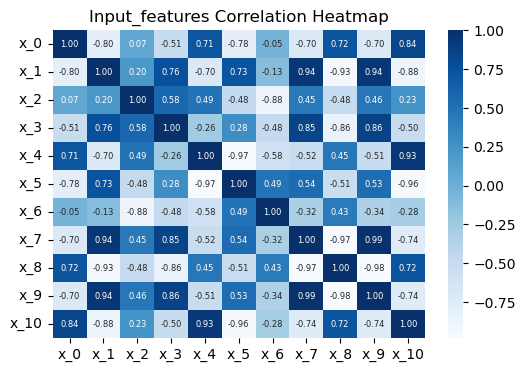

In [93]:
plt.subplots(figsize=(6,4))
sns.heatmap(train.corr(), fmt = '.2f', cmap = 'Blues', annot = True, annot_kws = {'size': 6})
plt.title('Input_features Correlation Heatmap')
plt.show()

In [94]:
vif_df = pd.DataFrame(index=train.columns)
vif_df["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif_df.T

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
VIF,2839.29541,1465.373664,19909.382794,1464.544254,3105.85077,63900.788983,18372.119851,1482.959207,40118.588079,6454.843181,1083.631926


## 오토인코더 사용, latent variable 추출

In [6]:
class early_stopping:
    def __init__(self, patience, delta):
        self.loss = float('inf')
        self.patience = patience
        self.delta = delta
        self.counter = 0

    def __call__(self, loss):
        if loss < self.loss + self.delta:
            self.loss = loss
        else: 
            self.counter += 1
            if self.counter == self.patience:
                return True
            return False

In [7]:
class private_datasets(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # x = torch.tensor(self.x.iloc[idx], dtypes = torch.float32)
        x= self.x.iloc[idx]
        return x

def collate_fn(batch): # 배치 단위 텐서/구조체로 변환하는 함수
    input = torch.tensor(batch, dtype = torch.float32)
    return input

tr_dataset = private_datasets(tr)
val_dataset = private_datasets(val)
test_dataset = private_datasets(test)

tr_dataloader = DataLoader(tr_dataset, batch_size=64, collate_fn=collate_fn, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, shuffle = False)

In [185]:
class Autoencoder(nn.Module):
    def __init__(self): # 직접 은닉층, 잠재 차원 정의 할 거면 여기서! hidden_dim, latent_dim) 선언
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
                nn.Linear(11, 20),
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 20), #  hidden_dim, latent_dim
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 50),
        ).to(device)
        
        self.decoder = nn.Sequential(
                nn.Linear(50, 20),  #  latent_dim, hidden_dim
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 11),
        ).to(device)


    
    

        self.optimizer = torch.optim.Adam(
            [
                        {'params' : self.encoder.parameters(), 'lr' : 5e-4, 'weight_decay': 0.001},
                        {'params' : self.decoder.parameters(), 'lr' : 5e-4, 'weight_decay': 0.001}
            ]
        )

        self.criterion = nn.MSELoss()

        # self.sparsity_weight = sparsity_weight
        # self.criterion = nn.HuberLoss()

    def forward(self, data):
        encoded = self.encoder(data)
        result_data = self.decoder(encoded)
        
        return result_data

    def sparsity_loss(self, latent_z):
        return torch.mean(torch.abs(latent_z))
        
        
    def train_autoencoder(self): # 메서드 명을 train으로 하면 self.train()에서 재귀에러 발생
        self.train()
        train_loss_list = []
        val_loss_list = []
        num_epochs = 0
        delta = 0.00001
        encoder_best_weight = None # 실제 테스트 데이터에 적용할 때는 인코더의 가중치만 필요
        patient_limit = 10
        patient_check = 0
        epochs = 100
        best_params = None
        init_val_loss = float('inf')
        for epoch in range(epochs):
            tr_loss = 0
            for tr_batch in tqdm(tr_dataloader, total = len(tr_dataloader)):
                tr_x = tr_batch
                tr_x = tr_x.to(device)
                self.optimizer.zero_grad()
                pred_feature= self.forward(tr_x)
                # loss = self.criterion(pred_feature, tr_x) + self.sparsity_weight * self.sparsity_loss(pred_feature)
                loss = self.criterion(pred_feature, tr_x)
                tr_loss += loss.item()
    
                loss.backward()
                clip_grad_norm_(self.parameters(), max_norm= 1.0)
            
                self.optimizer.step()
            train_loss_list.append(tr_loss / len(tr_dataloader))
            print(f'epoch: {epoch + 1}, 훈련 손실: {(tr_loss / len(tr_dataloader)) : 2f}')
            
            self.eval()
            val_loss = 0
            print_loss = 0
            with torch.no_grad():
                for val_batch in val_dataloader:
                    val_x = val_batch
                    val_x = val_batch.to(device)
                    preds = self.forward(val_x)
                    # loss = self.criterion(preds, val_x) + self.sparsity_weight * self.sparsity_loss(preds)
                    loss = self.criterion(preds, val_x)
                    val_loss += loss.item()
                
                print_loss = val_loss / len(val_dataloader)
                val_loss_list.append(print_loss)
                print(f'epoch: {epoch + 1}, 검증 손실: {np.round(print_loss,6)}')
                
                if print_loss < init_val_loss:
                    num_epochs = epoch + 1
                    patient_check = 0
                    init_val_loss = print_loss
                    encoder_best_weight = self.encoder.state_dict()
                    decoder_best_weight = self.decoder.state_dict()
                else:
                    patient_check += 1
        
            if patient_check == patient_limit:
                print(f"가중치 저장 시점 Epoch: {num_epochs}")
                print(f"검증 손실: {init_val_loss} ")
                print('****학습 종료****')
                break
       
        # weight_path  = 'sams_params/best_param_feature_extraction(60).pth'
        # torch.save(
        #     {
        #      'encoder_state_dict' : encoder_best_weight
        #      'decoder_state_dict' : decoder_best_weight
        #     }, weight_path
        #      )
        return train_loss_list, val_loss_list
auto_encoder = Autoencoder()

# 'sams_params/best_param_feature_extraction6.pth'  학습률 0.01 ,  epoch: 6, 훈련 손실:  0.003670  , 검증 손실: 0.005

In [186]:
set_seed(7)
tr_loss, val_loss = auto_encoder.train_autoencoder()

100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 260.22it/s]


epoch: 1, 훈련 손실:  0.306633
epoch: 1, 검증 손실: 0.009474


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 300.67it/s]


epoch: 2, 훈련 손실:  0.000792
epoch: 2, 검증 손실: 0.000261


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 293.90it/s]


epoch: 3, 훈련 손실:  0.000206
epoch: 3, 검증 손실: 0.000181


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 298.13it/s]


epoch: 4, 훈련 손실:  0.000172
epoch: 4, 검증 손실: 0.000167


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 269.25it/s]


epoch: 5, 훈련 손실:  0.000173
epoch: 5, 검증 손실: 0.000182


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 268.17it/s]


epoch: 6, 훈련 손실:  0.000206
epoch: 6, 검증 손실: 0.000225


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 282.93it/s]


epoch: 7, 훈련 손실:  0.000250
epoch: 7, 검증 손실: 0.000268


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 280.47it/s]


epoch: 8, 훈련 손실:  0.000291
epoch: 8, 검증 손실: 0.000321


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 258.72it/s]


epoch: 9, 훈련 손실:  0.000325
epoch: 9, 검증 손실: 0.000341


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 298.77it/s]


epoch: 10, 훈련 손실:  0.000334
epoch: 10, 검증 손실: 0.000339


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 296.93it/s]


epoch: 11, 훈련 손실:  0.000330
epoch: 11, 검증 손실: 0.000329


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 289.66it/s]


epoch: 12, 훈련 손실:  0.000328
epoch: 12, 검증 손실: 0.00034


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 297.65it/s]


epoch: 13, 훈련 손실:  0.000327
epoch: 13, 검증 손실: 0.000332


100%|███████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 297.88it/s]


epoch: 14, 훈련 손실:  0.000327
epoch: 14, 검증 손실: 0.000341
가중치 저장 시점 Epoch: 4
검증 손실: 0.00016744530806872283 
****학습 종료****


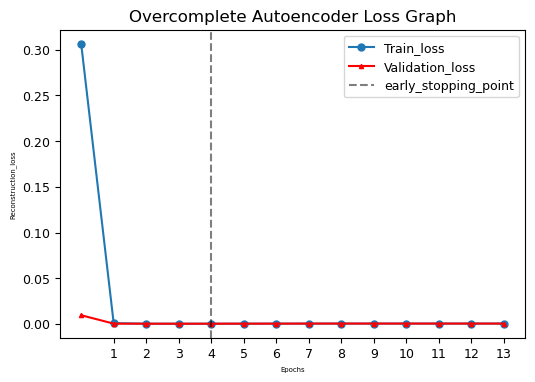

In [316]:
plt.subplots(1,1, figsize=(6,4))
epochs = np.arange(1,14)
plt.plot(tr_loss, marker = 'o', markersize = 5, label ='Train_loss')
plt.plot(val_loss, marker = '^', markersize = 3, color='r', label ='Validation_loss')
plt.axvline(x=4, color='black', linestyle='--', alpha=0.5, label ='early_stopping_point')
plt.xticks(epochs)

plt.xlabel("Epochs")
plt.ylabel("Reconstruction_loss")
plt.title("Overcomplete Autoencoder Loss Graph", fontsize = 12)

plt.tick_params('x',labelsize = 9)
plt.tick_params('y',labelsize = 9)
plt.legend(fontsize= 9)

In [179]:
# import gc
# del auto_encoder
# gc.collect()
# torch.cuda.empty_cache()

In [163]:
encoder = nn.Sequential(
                nn.Linear(11, 20),
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 20), #  hidden_dim, latent_dim
                nn.BatchNorm1d(20),
                nn.ReLU(),
                nn.Linear(20, 30),
        ).to(device)

check_point = torch.load('sams_params/best_param_feature_extraction(30).pth')  # 가중치가 float 32 타입으로 저장되기 때문에 형 변환 필요

encoder.load_state_dict(check_point['encoder_state_dict'])
# decoder.load_state_dict(check_point['decoder_state_dict'])

<All keys matched successfully>

In [164]:
def autoencoder_feature(data):
    encode_res = encoder(data)

    use_feature_to_numpy = encode_res.detach().cpu().numpy()
    return pd.DataFrame(use_feature_to_numpy)

ae_tr = autoencoder_feature(torch.tensor(tr.values, dtype = torch.float32).to(device))
ae_val = autoencoder_feature(torch.tensor(val.values, dtype = torch.float32).to(device))
ae_test = autoencoder_feature(torch.tensor(test.values, dtype = torch.float32).to(device))

for_tree_ae_tr = pd.concat([ae_tr, ae_val], axis=0)
for_tree_ae_tr_y = pd.concat([tr_y, val_y], axis= 0)

In [166]:
# OverComplete AutoEndoer 적용했을 때
start = time.time()

lgb_reg = lgb.LGBMRegressor(random_state=43, n_jobs=-1, verbose=-1)

lgbreg_random_params ={
            'max_depth' : [-1,3,4,5],  # 파라미터 지정하지 않으면 기본 값-1 부여 -> 이는 제한을 두지 않겠다는 의미
            'num_leaves' : [3,4,5,6,7],  # 트리 당 리프 개수  보통 2^max_depth 보다 1 작게!  (2^3-1 = 7)
            'n_estimators' : range(30,100,10),  # 트리 개수  보통 학습률 작으면 크게함, 너무 크면 과적합 위험 있음
            'min_child_samples': [20,21,22,23],  # 하위 노드 최소 데이터 개수 
            'learning_rate': np.arange(0.05, 0.2, 0.05),  # 학습률
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # 전체 데이터셋에서 사용할 데이터 비율 (일반화 성능, 과적합 방지 위한 파라미터)
            'colsample_bytree' : [0.6, 0.7, 0.8, 0.9, 1.0]  # 사용할 피쳐의 비율
        }

n_iter = 500

random_lgb_reg = RandomizedSearchCV(lgb_reg,
                                    param_distributions = lgbreg_random_params,
                                    n_iter = n_iter,
                                    cv = 5,
                                    scoring = 'neg_mean_squared_error',
                                    random_state=43
                                    )


random_lgb_reg.fit(for_tree_ae_tr, for_tree_ae_tr_y)

print(f'학습 소요시간:{np.round(time.time() - start, 0)}sec')

# 추가로, feature_importance 구할 수 있는데, 'gain' , 'split' 두 가지 기준이 존재
# split은 트리 내 분기 시 역핧을 크게 한 변수에 중요도를 더욱 부여하는 것이고
# gain은 말 그래도 정보 이득. 즉, pre_split, post_split간 차이를 보고 기여를 많이 한 변수에 중요도를 더욱 부여하는 것 

학습 소요시간:96.0sec


n_job = 1일 때 약 233초
device_type = gpu일 때 약 265초
n_job = -1일 때 약 66초  --> BEST!

latent 크기가 30인 경우의 소요시간이지만 소요시간 차이의 비율은 거의 유지됨

#### latent 30차원, 오토인코더 학습률 5e-4, weight_decay(L2) 1e-3, 클리핑 max_norm 1, 

In [168]:
vanila_lgb_result = pd.DataFrame(random_lgb_reg.cv_results_)
result_sorted = vanila_lgb_result.sort_values('mean_test_score', ascending=False)

ae_random_best_lgb = random_lgb_reg.best_estimator_
print(ae_random_best_lgb)
ae_random_best_lgb.fit(for_tree_ae_tr, for_tree_ae_tr_y)
ae_random_best_lgb_preds = ae_random_best_lgb.predict(ae_test)

ae_lgb_top_10_threshold = np.percentile(ae_random_best_lgb_preds, 90)
ae_lgb_pred_binary = (ae_random_best_lgb_preds >= ae_lgb_top_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'Top_10%_threshold :{ae_lgb_top_10_threshold}')
print("========================")
print(f'예측 값 상위 10% 중, 실제 상위 5% 포함 비율: {np.round(recall_score(true_binary, ae_lgb_pred_binary), 5)}')

LGBMRegressor(min_child_samples=22, n_estimators=60, n_jobs=-1, num_leaves=3,
              random_state=43, subsample=0.9, verbose=-1)
Top_10%_threshold :86.358240753605
예측 값 상위 10% 중, 실제 상위 5% 포함 비율: 0.89055


#### latent 40차원, 오토인코더 학습률 5e-4, weight_decay(L2) 1e-3, 클리핑 max_norm 1, 

In [162]:
vanila_lgb_result = pd.DataFrame(random_lgb_reg.cv_results_)
result_sorted = vanila_lgb_result.sort_values('mean_test_score', ascending=False)

ae_random_best_lgb = random_lgb_reg.best_estimator_
print(ae_random_best_lgb)
ae_random_best_lgb.fit(for_tree_ae_tr, for_tree_ae_tr_y)
ae_random_best_lgb_preds = ae_random_best_lgb.predict(ae_test)

ae_lgb_top_10_threshold = np.percentile(ae_random_best_lgb_preds, 90)
ae_lgb_pred_binary = (ae_random_best_lgb_preds >= ae_lgb_top_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'Top_10%_threshold :{ae_lgb_top_10_threshold}')
print("========================")
print(f'예측 값 상위 10% 중, 실제 상위 5% 포함 비율: {np.round(recall_score(true_binary, ae_lgb_pred_binary), 5)}')

LGBMRegressor(colsample_bytree=0.7, min_child_samples=23, n_estimators=70,
              n_jobs=-1, num_leaves=4, random_state=43, subsample=0.7,
              verbose=-1)
Top_10%_threshold :86.30191004283505
예측 값 상위 10% 중, 실제 상위 5% 포함 비율: 0.87065


#### latent 50차원, 오토인코더 학습률 5e-4, weight_decay(L2) 1e-3, 클리핑 max_norm 1, 

In [153]:
vanila_lgb_result = pd.DataFrame(random_lgb_reg.cv_results_)
result_sorted = vanila_lgb_result.sort_values('mean_test_score', ascending=False)

ae_random_best_lgb = random_lgb_reg.best_estimator_
print(ae_random_best_lgb)
ae_random_best_lgb.fit(for_tree_ae_tr, for_tree_ae_tr_y)
ae_random_best_lgb_preds = ae_random_best_lgb.predict(ae_test)

ae_lgb_top_10_threshold = np.percentile(ae_random_best_lgb_preds, 90)
ae_lgb_pred_binary = (ae_random_best_lgb_preds >= ae_lgb_top_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'Top_10%_threshold :{ae_lgb_top_10_threshold}')
print("========================")
print(f'예측 값 상위 10% 중, 실제 상위 5% 포함 비율: {np.round(recall_score(true_binary, ae_lgb_pred_binary), 5)}')

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.15000000000000002,
              max_depth=5, min_child_samples=22, n_estimators=60, n_jobs=-1,
              num_leaves=4, random_state=43, subsample=0.7, verbose=-1)
Top_10%_threshold :86.21537828631793
예측 값 상위 10% 중, 실제 상위 5% 포함 비율: 0.9005


#### latent 60차원, 오토인코더 학습률 5e-4, weight_decay(L2) 1e-3, 클리핑 max_norm 1, 

In [148]:
vanila_lgb_result = pd.DataFrame(random_lgb_reg.cv_results_)
result_sorted = vanila_lgb_result.sort_values('mean_test_score', ascending=False)

ae_random_best_lgb = random_lgb_reg.best_estimator_
print(ae_random_best_lgb)
ae_random_best_lgb.fit(for_tree_ae_tr, for_tree_ae_tr_y)
ae_random_best_lgb_preds = ae_random_best_lgb.predict(ae_test)

ae_lgb_top_10_threshold = np.percentile(ae_random_best_lgb_preds, 90)
ae_lgb_pred_binary = (ae_random_best_lgb_preds >= ae_lgb_top_10_threshold).astype('int')

# 실제 값 중 상위 5% 선별
true_5_threshold = np.percentile(test_y, 95)
true_binary = (test_y >= true_5_threshold).astype('int')

print(f'Top_10%_threshold :{ae_lgb_top_10_threshold}')
print("========================")
print(f'예측 값 상위 10% 중, 실제 상위 5% 포함 비율: {np.round(recall_score(true_binary, ae_lgb_pred_binary), 5)}')

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.15000000000000002,
              max_depth=3, min_child_samples=22, n_estimators=30, n_jobs=-1,
              num_leaves=5, random_state=43, verbose=-1)
Top_10%_threshold :86.34275088082336
예측 값 상위 10% 중, 실제 상위 5% 포함 비율: 0.88557


### Kmeans + silhouette_score

In [363]:
# Within-Cluster Sum of Squares (wcss)
wcss = []
ks = range(1,10)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(for_tree_tr.values)
    wcss.append(kmeans.inertia_)


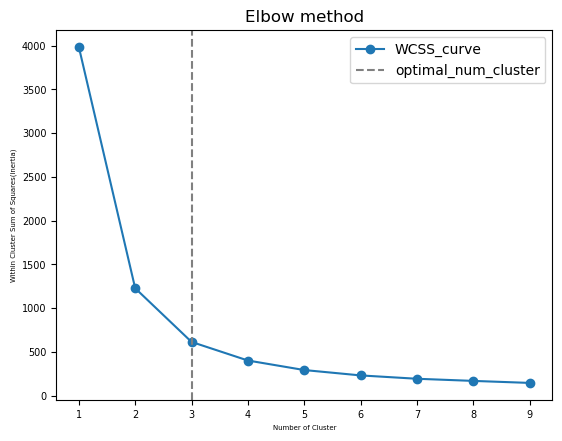

In [403]:
plt.plot(ks, wcss, marker = 'o', label = 'WCSS_curve')
plt.xticks(np.arange(1,10))
plt.axvline(3, linestyle='--', color= 'grey', label = 'optimal_num_cluster')
plt.xlabel('Number of Cluster')
plt.ylabel('Within Cluster Sum of Squares(inertia)')
plt.legend(fontsize=10)
plt.title("Elbow method", fontsize= 12)
plt.tick_params('x', labelsize= 7)
plt.tick_params('y', labelsize= 7)

In [417]:
kmeans = KMeans(n_clusters=3, random_state=0)

v_predict = kmeans.fit_predict(for_tree_tr.values)
ae_predict = kmeans.fit_predict(for_tree_ae_tr.values)

v_sil = silhouette_score(for_tree_tr.values, v_predict)
ae_sil = silhouette_score(for_tree_ae_tr.values, ae_predict)

print(f"기본 데이터 실루엣 계수: {v_sil}")
print(f"AE 변형 데이터 실루엣 계수: {ae_sil}")
print("===================================================")
print(f"실루엣 계수 차이: {ae_sil - v_sil}")

기본 데이터 실루엣 계수: 0.5767453991017194
AE 변형 데이터 실루엣 계수: 0.6880526542663574
실루엣 계수 차이: 0.11130725516463802


In [426]:
v_ch = calinski_harabasz_score(for_tree_tr.values, v_predict)
ae_ch = calinski_harabasz_score(for_tree_ae_tr.values, ae_predict)

print(f"기본 데이터 CH: {v_ch}")
print(f"AE 변형 데이터 CH: {ae_ch}")
print("===================================================")
print(f"분산 차이 Ratio: {ae_ch / v_ch}")

기본 데이터 CH: 98984.48767141283
AE 변형 데이터 CH: 376258.0995619912
분산 차이 Ratio: 3.8011824722577847
